# Exercises for Introduction to Python for Data Science

Week 10 - scikit-learn

Matthias Feurer and Andreas Bender  
2025-07-07

# Setup

Check that you have at least **scikit‑learn ≥ 1.4** and
**pandas ≥ 2.0**.

    import sklearn, pandas as pd, numpy as np
    print("scikit‑learn", sklearn.__version__)
    print("pandas", pd.__version__)

# Exercise 1: Download an appropriate dataset

In [ ]:
import sklearn, pandas as pd, numpy as np

from sklearn.datasets import fetch_openml
X, y =fetch_openml(
    "house_prices",
    version=1,
    as_frame=True ,#pandas格式
    parser='pandas', #pandas interpreter
    return_X_y = True #返回（x,y）tuple 而不是bunch对象
)
print(X.shape, y.shape)

(1460, 80) (1460,)


*Download a tabular regression dataset that already contains categorical
columns **and** missing values.* Two popular options:

1.  **Ames Housing** — numeric + categorical + some NaNs.

2.  **Mercedes‑Benz Greener Manufacturing** (*OpenML ID = 42165*) if you
    prefer a smaller data set.

Store **features** `X` and **target** `y` as Pandas objects—no NumPy
arrays outside the pipeline!

# Exercise 2: Pipeline

Your end‑to‑end pipeline must:

1.  **Impute missing values**

    -   Numeric → Impute using the mean.
    -   Categorical → Create a new category that indicates missing data.

2.  **Encode categoricals** with
    `OneHotEncoder(handle_unknown="ignore", sparse_output=False)`.

3.  **Scale numerical features** so that they have zero mean and unit
    variance.

4.  **Parallel feature branches**: create three parallel feature
    branches where the data is processed in differen manners:

    -   **Branch A** — use only simple preprocessing (steps 1-3).
    -   **Branch B** — apply principal component analysis.
    -   **Branch C** — apply k-means clustering and add new features
        that measure the distance to all cluster centers.

5.  **Regressor**: Use ridge regression and tune the regularization
    hyperparameter.

6.  **Target scaling**: scale the target so it automatically has zero
    mean and unit variance.

Everything must be wired up in a single `Pipeline` so that a call to
**`fit()`** triggers *all* preprocessing.

HINTS: \* Call `set_output(transform="pandas")` **once** to make every
transformer emit data frames → keeps column names alive. \* You need to
use `ColumnTransformer`, `Pipeline` and `FeatureUnion` in order to solve
this exercise.

In [ ]:
from math import frexp
import joblib
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn import clone
num_selector = make_column_selector(dtype_include=np.number)
cat_selector = make_column_selector(dtype_exclude=np.number)
num_pipe =Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler())
])
#sparse_output=False：输出密集矩阵
cat_pipe = Pipeline([
    ("one hot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
branch_A = ColumnTransformer([
    ("num",clone(num_pipe), num_selector ),
    ("cat", clone(cat_pipe), cat_selector),
],remainder='drop',verbose_feature_names_out=False)
#Branch B — apply principal component analysis.-> pca
branch_B = Pipeline([
    ("preprocess",clone(branch_A)),
    ("normalize",clone(num_pipe)),
    ("pca",PCA(n_components=0.95,random_state=42)),
])
#Branch C — apply k-means clustering and add new features
#that measure the distance to all cluster centers.
branch_C = Pipeline([
    ('preprocess',clone(branch_A)),
    ('nomalize', clone(num_pipe)),
    ('Kmeans',KMeans(n_init=10,n_clusters=10))
])
#组合所有分支
feature_union= FeatureUnion([
    ("branch A", clone(branch_A)),
    ("branch_B", branch_B),
    ("branch_C",branch_C)
]
)
# ensure Pandas output everywhere
feature_union.set_output(transform="pandas")

#Regressor: Use ridge regression and tune the regularization hyperparameter.
reg = TransformedTargetRegressor(
    regressor = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]),
    transformer = StandardScaler()
)
pipe = Pipeline([
    ("features", feature_union),
    ("regressor", reg)
])

# Exercise 3: Cross-Validation

-   Use **10‑fold cross‑validation** (you can start with 2-fold
    cross-validation for development):
-   Compare against a *baseline* that simply imputes + encodes and uses
    the same linear models (no PCA/Clustering). Did the extra branches
    help?

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#返回rmse
scores = cross_val_score(pipe,
                         X,y,
                         cv=cv,
                         scoring="neg_root_mean_squared_error",
                         n_jobs=-1)
print(f"{-scores.mean():.3f}+/-{scores.std():.3f}")
#compare with no pca/clustering
base_pipe = Pipeline([
    ("data process",clone(branch_A)),
    ("reg",reg)
]
)
base_scores = cross_val_score(base_pipe,
                              X,y,
                              cv=cv,
                              scoring="neg_root_mean_squared_error",
                              n_jobs=-1)
print(f"{-base_scores.mean():.3f}+/-{base_scores.std():.3f}")


31623.444+/-8297.968
31451.522+/-10471.865


Using all three pre-processing strategies in parallel results in a
slight performance improvement.

# Exercise 4: Bonus tasks

-   Swap the linear model for `HistGradientBoostingRegressor` and
    compare.
-   Swap the linear model for `DecisionTreeRegressor`, compare, and plot
    the decision tree.
-   Run **nested CV** with `RandomizeSearchCV` tuning `n_clusters` and
    `n_components`.
-   Persit and re-load the model using `joblib.dump` and `joblib.load`.

32873.697277651634+/-6709.783591308505
39826.893998194064+/-6709.783591308505


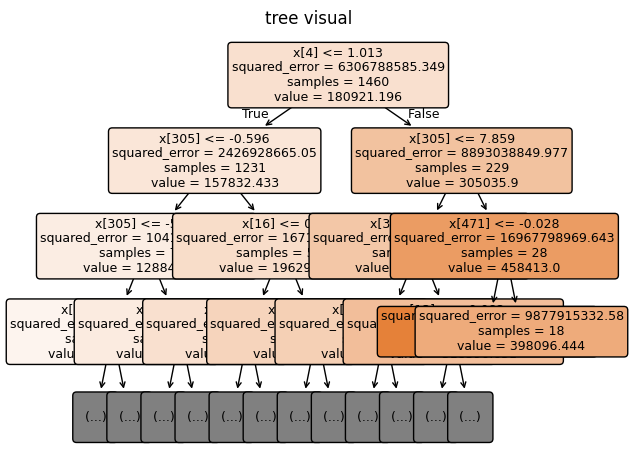

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np
reg_new = DecisionTreeRegressor(
    max_depth = 10,
    min_samples_split= 20,
    min_samples_leaf = 10,
    random_state=42
)
pipe_new = Pipeline([
    ("features", feature_union),
    ("regressor", reg_new)
])
#cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe,
                         X,y,
                         cv=cv,
                         scoring="neg_root_mean_squared_error",
                         n_jobs=-1)
tree_scores = cross_val_score(pipe_new,
                              X,y,
                              cv=cv,
                              scoring="neg_root_mean_squared_error",
                         n_jobs=-1)
print(f"{-scores.mean()}+/-{scores.std()}")
print(f"{-tree_scores.mean()}+/-{scores.std()}")
pipe_new.fit(X,y)
trained_tree= pipe_new.named_steps['regressor']
fig,ax= plt.subplots()
plot_tree(trained_tree,
          ax=ax,
          max_depth=3,
          filled = True,
          rounded=True,
          fontsize=9)
ax.set_title("tree visual")
plt.tight_layout()
plt.show()

Swap the linear model for HistGradientBoostingRegressor and compare

In [ ]:

# 简洁代码：HistGradientBoostingRegressor vs Ridge 比较

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# 创建HistGradientBoostingRegressor
hist_reg = HistGradientBoostingRegressor(
    random_state=42,
    max_iter=100  # 控制训练时间
)

# 创建两个流水线进行比较
pipe_ridge = Pipeline([
    ("features", feature_union),
    ("regressor", reg)  # 原来的Ridge回归器
])

pipe_hist = Pipeline([
    ("features", feature_union),
    ("regressor", hist_reg)  # 新的HistGradientBoosting回归器
])

# 交叉验证比较
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("进行交叉验证比较...")

# Ridge回归结果
ridge_scores = cross_val_score(pipe_ridge, X, y,
                              cv=cv,
                              scoring="neg_root_mean_squared_error",
                              n_jobs=-1)

# HistGradientBoosting回归结果
hist_scores = cross_val_score(pipe_hist, X, y,
                             cv=cv,
                             scoring="neg_root_mean_squared_error",
                             n_jobs=-1)

# 打印结果
print("\n" + "="*50)
print("模型性能比较")
print("="*50)
print(f"Ridge Regression:           {-ridge_scores.mean():.1f} ± {ridge_scores.std():.1f}")
print(f"HistGradientBoosting:       {-hist_scores.mean():.1f} ± {hist_scores.std():.1f}")

# 计算改进
improvement = -ridge_scores.mean() - (-hist_scores.mean())
improvement_pct = (improvement / (-ridge_scores.mean())) * 100

print(f"\n改进情况:")
if improvement > 0:
    print(f"✓ HistGradientBoosting 更好，改进了 {improvement:.1f} RMSE ({improvement_pct:.2f}%)")
else:
    print(f"✗ Ridge 更好，HistGradientBoosting 差了 {abs(improvement):.1f} RMSE ({abs(improvement_pct):.2f}%)")

# 稳定性比较
print(f"\n稳定性比较:")
print(f"Ridge 标准差:                {ridge_scores.std():.1f}")
print(f"HistGradientBoosting 标准差:  {hist_scores.std():.1f}")

if hist_scores.std() < ridge_scores.std():
    print("✓ HistGradientBoosting 更稳定")
else:
    print("✓ Ridge 更稳定")

Run nested CV with RandomizeSearchCV tuning n_clusters and n_components.

In [ ]:
# 简洁版：嵌套交叉验证调优n_clusters和n_components

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold

# 参数搜索空间
param_grid = {
    'features__pca__pca__n_components': [10, 20, 0.90, 0.95],
    'features__cluster__cluster__n_clusters': [5, 10, 15, 20]
}

# RandomizedSearchCV（内层CV）
search = RandomizedSearchCV(
    pipe,                    # 使用你已有的复杂流水线
    param_grid,
    n_iter=8,               # 8种组合
    cv=3,                   # 内层3折
    scoring='neg_root_mean_squared_error',
    random_state=42
)

# 嵌套交叉验证（外层CV）
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = cross_val_score(search, X, y, cv=outer_cv,
                               scoring='neg_root_mean_squared_error')

# 结果
print(f"嵌套CV RMSE: {-nested_scores.mean():.1f} ± {nested_scores.std():.1f}")

# 找最佳参数
search.fit(X, y)
print(f"最佳参数: {search.best_params_}")

In [ ]:
# 简洁版：模型持久化 - 保存和加载模型

import joblib
import numpy as np

# 1. 训练模型
print("训练模型...")
pipe.fit(X, y)

# 2. 保存模型
model_filename = 'housing_price_model.pkl'
print(f"保存模型到 {model_filename}...")
joblib.dump(pipe, model_filename)

# 3. 加载模型
print(f"从 {model_filename} 加载模型...")
loaded_pipe = joblib.load(model_filename)

# 4. 验证模型是否正确加载
print("\n验证模型加载...")

# 原始模型预测
original_predictions = pipe.predict(X[:5])  # 前5个样本
print(f"原始模型预测: {original_predictions}")

# 加载模型预测
loaded_predictions = loaded_pipe.predict(X[:5])  # 前5个样本
print(f"加载模型预测: {loaded_predictions}")

# 检查预测结果是否一致
are_identical = np.allclose(original_predictions, loaded_predictions)
print(f"预测结果一致: {are_identical}")

# 5. 模型信息
import os
file_size = os.path.getsize(model_filename) / (1024 * 1024)  # MB
print(f"\n模型文件大小: {file_size:.2f} MB")
print(f"模型保存成功! ✅")

# 6. 使用加载的模型进行新预测
print(f"\n使用加载的模型进行预测...")
sample_prediction = loaded_pipe.predict(X[:1])
print(f"单个样本预测: ${sample_prediction[0]:,.0f}")